# Concept

The goal here is to build a sequential web scraper based off of the TTBID. I think that the simplest thing to do will just be to start with a basic easy date and then just increment until we get an error back. Since things are _supposedly_ sequential, we can interate easily. A good test will be to try for a small test range. It may also be worth trying to get those parallel scraping tools operational

<div class="alert alert-block alert-info">
TTB ID - This is a unique, 14 digit number assigned by TTB to track each COLA.  The first 5 digits represent the calendar year and Julian date the application was received by TTB. The next 3 digits tell how the application was received (001 = e-filed; 002 & 003 = mailed/overnight; 000 = hand delivered). The last 6 digits is a sequential number that resets for each day and for each received code.
</div>

# Imports

In [85]:
import requests
from bs4 import BeautifulSoup
import re

import datetime
import pymongo
import warnings

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')


import sys
sys.path.append(r'../ScrapingTools')
from TTB_scraping import TTB_Scraper
from time import sleep


### Early prototypes

In [121]:
start_date = '01/30/2016'
stop_date = '01/01/2017'

In [ ]:
f = open('logfile.txt', 'w')

# Set up connection to mongodb
client = pymongo.MongoClient() # Connect to default client
db = client.TTB # Get a database (note: lazy evaluation)
TTB = db.TTB # the actual collection

# convert dates to datetime format
date_start = datetime.datetime.strptime(start_date, '%m/%d/%Y')
date_stop = datetime.datetime.strptime(stop_date, '%m/%d/%Y')

# iterate over each date
curr_date = date_start
while (curr_date < date_stop):
    print('Now on:  {}'.format(curr_date.strftime('%m/%d/%Y')))
    # iterate over each recieve code
    curr_reccode = 0
    while curr_reccode <= 3:

        # increment each sequence 
        cont_seq = True
        curr_seqnum = 1
        retry_count = 0
        while cont_seq:
            # prep the strings for the ttbid
            jdate='{year}{day}'.format(year=curr_date.strftime('%y'), day=curr_date.strftime('%j'))
            reccode='{:03d}'.format(curr_reccode)
            seqnum='{:06d}'.format(curr_seqnum)

            # prep the query
            ttbid = '{jdate}{reccode}{seqnum}'.format(jdate=jdate, reccode=reccode, seqnum=seqnum)

            query = TTB_Scraper(ttbid)
            parsed_data = query.get_basic_form_data()

            # if we got a valid response
            if parsed_data:
                query_data = {'_id': ttbid,
                         'recieve_date':curr_date.strftime('%m/%d/%Y'),
                         'recieve_code': reccode,
                         'seq_num': seqnum}
                
                # concatinated data we will add to our database
                output = {**query_data, **parsed_data}

                curr_seqnum += 1
                retry_count = 0
                # Insert result into database
                try:
                    TTB.insert_one(output)
                    #print('Successfully added: {}'.format(ttbid))
                    f.write('{},1\n'.format(ttbid))
                except pymongo.errors.DuplicateKeyError:
                    warnings.warn('_id: {ttbid} is already in database, skipping...'.format(ttbid=ttbid))
            else:
                # stick with this sequence
                if retry_count < 3:
                    curr_seqnum += 1
                    retry_count += 1
                else:
                    cont_seq = False
                f.write('{},0\n'.format(ttbid))

            sleep(0.1)
        curr_reccode += 1
    curr_date += datetime.timedelta(days=1)

f.close()

Now on:  01/30/2016
Now on:  01/31/2016
Now on:  02/01/2016
Now on:  05/20/2016
Now on:  05/21/2016
Now on:  05/22/2016
Now on:  05/23/2016
Now on:  05/24/2016
Now on:  05/25/2016
Now on:  05/26/2016
Now on:  05/27/2016
Now on:  05/28/2016
Now on:  05/29/2016
Now on:  05/30/2016
Now on:  05/31/2016
Now on:  06/01/2016
Now on:  06/02/2016
Now on:  06/03/2016
Now on:  06/04/2016
Now on:  06/05/2016
Now on:  06/06/2016
Now on:  06/07/2016
Now on:  06/08/2016
Now on:  06/09/2016
Now on:  06/10/2016
Now on:  06/11/2016
Now on:  06/12/2016
Now on:  06/13/2016
Now on:  06/14/2016
Now on:  06/15/2016
Now on:  06/16/2016
Now on:  06/17/2016
Now on:  06/18/2016
Now on:  06/19/2016
Now on:  06/20/2016
Now on:  06/21/2016
Now on:  06/22/2016
Now on:  06/23/2016
Now on:  06/24/2016
Now on:  06/25/2016
Now on:  06/26/2016
Now on:  06/27/2016
Now on:  06/28/2016
Now on:  06/29/2016
Now on:  06/30/2016
Now on:  07/01/2016
Now on:  07/02/2016
Now on:  07/03/2016
Now on:  07/04/2016
Now on:  07/05/2016


In [88]:
curr_reccode

4

In [93]:
ttbid

'16251001000019'

In [9]:
output

{'ApprovalDate': '01/20/2016',
 'BrandName': 'RUBOR VITICULTORES',
 'Class/TypeCode': 'DESSERT /PORT/SHERRY/(COOKING) WINE',
 'ContactInformation': 'CHRISTOPHERTERRELL\nPhone Number:(510) 717-4829\nFax Number:(419) 710-4829\n',
 'FancifulName': '',
 'ForSaleIn': '',
 'Formula': '',
 'GrapeVarietal(s)': 'N/A',
 'OriginCode': 'SPAIN',
 'PlantRegistry/BasicPermit/BrewersNo(Other)': '',
 'PlantRegistry/BasicPermit/BrewersNo(PrincipalPlaceofBusiness)': 'CA-I-15980\nTERRELL WINES, CHRISTOPHER JAMES TERRELL\n751 13TH ST , TREASURE ISLAND\nSAN FRANCISCO, CA 94130\n',
 'Qualifications': 'TTB has not reviewed this label for type size, characters per inch or contrasting background.The responsible industry member must continue to ensure that the mandatory information on the actual labels is displayed in the correct type size, number of characters per inch, and on a contrasting background in accordance with the TTB labeling regulations, 27 CFR parts 4, 5, 7, and 16, as applicable.\nTTB has not revi

In [13]:
assert(output['TTBID'] == output['_id'])

In [14]:
# Set up connection to mongodb
client = pymongo.MongoClient() # Connect to default client
db = client.TTB # Get a database (note: lazy evaluation)
TTB = db.TTB # the actual collection

In [26]:
try:
    res = TTB.insert_one(output)
except pymongo.errors.DuplicateKeyError:
    warnings.warn('_id: {ttbid} is already in database, skipping...'.format(ttbid=ttbid))

/opt/conda/envs/datainc/lib/python3.6/site-packages/ipykernel/__main__.py:4: UserWarning: _id: 16001001000001 is already in database, skipping...


In [17]:
res.inserted

'16001001000001'

In [111]:
ttbid = 16004001000014
query = TTB_Scraper(ttbid)
data = query.get_basic_form_data()
data

In [ ]:
def build_ttb_database(start_date, stop_date):

# Getting data from the Mongo DB

In [90]:
# Set up connection to mongodb
client = pymongo.MongoClient() # Connect to default client
db = client.TTB # Get a database (note: lazy evaluation)
TTB = db.TTB # the actual collection

In [128]:
TTB.count() # number of elements in the database

85213

In [103]:
a = TTB.distinct('TTBID') # list of distinct TTBID's
len(a)

424

In [34]:
TTB.find_one('16001001000002')

{'ApprovalDate': '01/19/2016',
 'BrandName': 'RUBOR VITICULTORES',
 'Class/TypeCode': 'DESSERT /PORT/SHERRY/(COOKING) WINE',
 'ContactInformation': 'CHRISTOPHERTERRELL\nPhone Number:(510) 717-4829\nFax Number:(419) 710-4829\n',
 'FancifulName': '',
 'ForSaleIn': '',
 'Formula': '',
 'GrapeVarietal(s)': 'N/A',
 'OriginCode': 'SPAIN',
 'PlantRegistry/BasicPermit/BrewersNo(Other)': '',
 'PlantRegistry/BasicPermit/BrewersNo(PrincipalPlaceofBusiness)': 'CA-I-15980\nTERRELL WINES, CHRISTOPHER JAMES TERRELL\n751 13TH ST , TREASURE ISLAND\nSAN FRANCISCO, CA 94130\n',
 'Qualifications': 'TTB has not reviewed this label for type size, characters per inch or contrasting background.The responsible industry member must continue to ensure that the mandatory information on the actual labels is displayed in the correct type size, number of characters per inch, and on a contrasting background in accordance with the TTB labeling regulations, 27 CFR parts 4, 5, 7, and 16, as applicable.\nTTB has not revi

We can preint out some basic stats like so:

In [120]:
# print collection statistics
#print(db.command("collstats", "TTB"))

# print database statistics
print(db.command({"dbstats": 1,  'scale': 1024}))

{'db': 'TTB', 'collections': 1, 'views': 0, 'objects': 8321, 'avgObjSize': 1709.1797860834035, 'dataSize': 13888.7548828125, 'storageSize': 4068.0, 'numExtents': 0, 'indexes': 1, 'indexSize': 128.0, 'ok': 1.0}


Estimate for one year's worth of entries

In [50]:
(208/408) * 147073

74978.39215686274

In [117]:
# WARNING: deletes database?
#client.drop_database('TTB')

# Mongo into Pandas

The following snippet _should_ turn every element of our mongodb into a list which is then parsed by pandas into a df

In [124]:
df = pd.DataFrame(list(TTB.find()))

In [125]:
df.columns

Index(['ApprovalDate', 'BrandName', 'Class/TypeCode', 'ContactInformation',
       'FancifulName', 'ForSaleIn', 'Formula', 'GrapeVarietal(s)',
       'OriginCode', 'PlantRegistry/BasicPermit/BrewersNo(Other)',
       'PlantRegistry/BasicPermit/BrewersNo(PrincipalPlaceofBusiness)',
       'Qualifications', 'Serial#', 'Status', 'TTBID', 'TotalBottleCapacity',
       'TypeofApplication', 'VendorCode', 'WineVintage', '_id', 'recieve_code',
       'recieve_date', 'seq_num'],
      dtype='object')

In [126]:
df['TTBID'] = df['TTBID'].apply(pd.to_numeric)

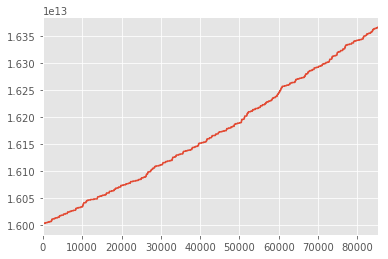

In [127]:
df['TTBID'].plot()
plt.show()

In [133]:
by_status = df.groupby('Status')

In [136]:
approved_only = df.loc[df['Status'] == 'APPROVED']

In [141]:
# get list of all US states, convert to uppercase as that is what is used
states = ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']
states = [state.upper() for state in states]

In [144]:
us_only = df.loc[df['OriginCode'].isin(states)]
us_only.head()
us_only['_id'].count()

38538